# Notebook 5 - Marine Isotope Stage (MIS) Analysis

Load data and external records for comparison. Apply low pass filter and find MIS values following approach of [the PAGES interglacial working group](https://doi.org/10.1002/2015RG000482)

This notebooks outputs the following figures:
- SF5: Finding MIS values for each record
- SF6: Correlation heatmap between records in the MIS ensemble table (interglacials)
- SF7: Bootstrap correlation coefficient between SS and AIS models

In [2]:
cd '/Users/starr/My Drive/Files/Projects/U1475/subproject_repos/SS_Paper/Starr_etal_ACC'

/Users/starr/My Drive/Files/Projects/U1475/subproject_repos/SS_Paper/Starr_etal_ACC


In [3]:
# preamble
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style="ticks")

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import signal,stats
from scipy.interpolate import interp1d

### DONT DO THIS
import warnings
warnings.filterwarnings("ignore")
####

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 10
mpl.rcParams["mathtext.fontset"] = "dejavusans"

plt.style.use('default')

mis_bounds = pd.read_csv('data/misc/LR04_MISboundaries.txt')
# remove sub-stages from table\n",
mis_bounds.drop([4,5,6,7,8],inplace=True)
mis_bounds.iloc[-1] = {'MIS':'0/1','Age(ka)':0}
mis_bounds.sort_values('Age(ka)',inplace=True)
mis_bounds.reset_index(drop=True,inplace=True)

### define age_model function
def age_model(depth_in,ties):
    f = interp1d(ties.iloc[:,0],ties.iloc[:,1],fill_value='extrapolate')
    age = f(depth_in)
    return age

In [4]:
mis_bounds

,MIS,Age(ka)
0,0/1,0.0
1,1/2,14.0
2,2/3,29.0
3,3/4,57.0
4,4/5,71.0
...,...,...
222,T8/TG1,5188.0
223,TG1/TG2,5241.0
224,TG2/TG3,5266.0
225,TG3/TG4,5289.0


In [5]:
#### important functions

inds = np.arange(0,150,1)

### assing MIS labels to each index of a dataframe
def find_MIS_values(t,mis_bounds,sub=False):
    """
    t: time
    sub: include substages? default sub=False
    """
    inds = np.arange(0,150,1)
    results = np.empty(len(t)) # initialize results list
    for i in inds:
        i1 = mis_bounds['Age(ka)'].loc[i]
        i2 = mis_bounds['Age(ka)'].loc[i+1]
        idx = (t>=i1)&(t<=i2)
        results[idx] = i+1
    
    return results

#### filtering functions
def filtered(x,y,highcut,tnew = [0,0],newdt = 0):
    """ 
    Interpolate to linear scale and apply low-pass butterworth filter 
    """
    if newdt == 0:
        fs = np.mean(np.diff(x))
    else:
        fs = newdt

    if len(tnew)>2:
        x_lin = tnew
        fs = np.mean(np.diff(tnew))
    else:
        minx = np.min(x)+1
        maxx = np.max(x)-1
        x_lin = np.arange(minx,maxx,fs)
    f = interp1d(x,y,fill_value='extrapolate')
    y_lin = f(x_lin)
    y_filt = butter_lowpass_filter(y_lin, highcut, 1/fs, order=5)
    return x_lin, y_filt, y_lin

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut/nyq
    b, a = signal.butter(order, high, btype='low',analog=False)
    return b, a

def butter_lowpass_filter(data, highcut, fs = 0.5, order=6):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

----
## Load external data

| Record | Variable | Reference | DOI |
|--------|---|---| ---|
| simulated AIS volume | `deboer` | De Boer et al., 2014 | https://doi.org/10.1038/ncomms3999 |
| simulated atmospheric CO2 conc | `stap` | Stap et al., 2016 |  doi:10.1016/j.epsl.2016.01.022 |
| Global Average Surface Temp. reconstruction | `GAST` | Snyder, 2016 | https://doi.org/10.1038/nature19798 |
| ODP Site 1090 SST (alkenone derived) | `odp1090` | Martinez-Garcia et al., 2009 | https://doi.org/10.1029/2008PA001657 |
| Global Relative Sea Level reconstruction | `rsl` | Miller et al., 2020 | DOI: 10.1126/sciadv.aaz1346 | 
| PS97/093 Sortable Silt record | `ps97` | Toyos et al., 2020 | https://doi.org/10.1594/PANGAEA.905988 |
| U1540/U1541 Sortable Silt records | `u1541`, `u1540` | Lamy et al., 2024 | https://doi.org/10.1594/PANGAEA.965443 |

In [6]:
### Load Data
#### apcomp
apcomp = pd.read_csv('tables/ap_comp_ss.csv')

### De Boer ice sheet model
deboer = pd.read_excel('data/external_data.xlsx',sheet_name='ANICE_model',header=16)
deboer = deboer.sort_values(by='Age').reset_index()

### PS97_093
ps97 = pd.read_csv('tables/ps97_ss.csv')

### GAST (Snyder)
gast = pd.read_excel('data/external_data.xlsx',sheet_name='GAST',header=12)

### ODP 1090 SST
odp1090 = pd.read_excel('data/external_data.xlsx',sheet_name='ODP1090_SST',header=7)

### Relative Sea Level
rsl = pd.read_excel('data/external_data.xlsx',sheet_name='RSL',header=9)

### U1540 / U1541
u1540 = pd.read_csv('tables/u1540_ss.csv')
u1541 = pd.read_csv('tables/u1541_ss.csv')


In [7]:
lpf = 1/5 # frequency to filter records at
newdt = 2 # time step for linear interpolation (set to 0 to use average spacing instead)

In [8]:
ps97

,Unnamed: 0,Depth [m],Age [ka BP],Revised Age (Starr),SS avg [µm],SS_dHolocene,dU_dhol_mccave,dU_dhol_mccave_2std,dU_dhol_wu,pct_dU_dHol_wu,dU_dhol_culp
0,0,0.005,4.16,4.160000,26.22,0.30,0.4080,0.0570,0.2280,1.157407,0.4230
1,1,0.025,5.13,5.128511,25.62,-0.30,-0.4080,-0.0570,-0.2280,-1.157407,-0.4230
2,2,0.065,7.08,7.065532,25.38,-0.54,-0.7344,-0.1026,-0.4104,-2.083333,-0.7614
3,3,0.085,8.06,8.034043,24.96,-0.96,-1.3056,-0.1824,-0.7296,-3.703704,-1.3536
4,4,0.125,10.01,9.971064,25.91,-0.01,-0.0136,-0.0019,-0.0076,-0.038580,-0.0141
...,...,...,...,...,...,...,...,...,...,...,...
3067,3067,16.380,1364.98,1364.980000,22.29,-3.63,-4.9368,-0.6897,-2.7588,-14.004630,-5.1183
3068,3068,16.385,1365.19,1365.190000,22.03,-3.89,-5.2904,-0.7391,-2.9564,-15.007716,-5.4849
3069,3069,16.390,1365.39,1365.390000,22.03,-3.89,-5.2904,-0.7391,-2.9564,-15.007716,-5.4849
3070,3070,16.395,1365.59,1365.590000,22.03,-3.89,-5.2904,-0.7391,-2.9564,-15.007716,-5.4849


In [9]:
######### RUN THIS CELL TO FIND MIS VALUES ###############
lp = pd.DataFrame() # init dataframe
 
#### --- APcomp --- ####
apcomp['MIS'] = find_MIS_values(apcomp['LR04_age'],mis_bounds)

# benthic d18O
n = apcomp['Cwu d18O (VPDB)'].notnull() # find nans
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['Cwu d18O (VPDB)'][n],lpf,newdt=newdt) # low pass filter and return
lp['age'] = t
lp['c18O'] = pp
lp['c18O_lpf'] = y

# Sortable Silt
n = apcomp['dU_dhol_mccave'].notnull()
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['dU_dhol_mccave'][n],lpf,tnew=t)
lp['SS'] = pp
lp['SS_lpf'] = y

# d13C benthic
n = apcomp['Cwu d13C (VPDB)'].notnull()
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['Cwu d13C (VPDB)'][n],lpf,tnew=t)
lp['c13C'] = pp
lp['c13C_lpf'] = y

# IRD
n = apcomp['IRD MAR '].notnull()
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['IRD MAR '][n],lpf,tnew=t)
lp['IRD'] = pp
lp['IRD_lpf'] = y


# ##### ----------- external records ----------- ##########

# #### --- PS97/093 --- ####
ps97['MIS'] = find_MIS_values(ps97['Revised Age (Starr)'],mis_bounds)
n = ps97['dU_dhol_wu'].notnull()
t_0,y,pp = filtered(ps97['Revised Age (Starr)'][n],ps97['dU_dhol_wu'][n],lpf,tnew=lp['age'])
lp['ps97_SS'] = pp
lp['ps97_SS_lpf'] = y

# #### --- U1540 --- ####
u1540['MIS'] = find_MIS_values(u1540['Age [ka BP]'],mis_bounds)
n = u1540['dU_dhol_mccave'].notnull()
t_0,y,pp = filtered(u1540['Age [ka BP]'][n],u1540['dU_dhol_mccave'][n],lpf,tnew=lp['age'])
lp['u1540_SS'] = pp
lp['u1540_SS_lpf'] = y

# #### --- U1541 --- ####
u1541['MIS'] = find_MIS_values(u1541['Age [ka BP]'],mis_bounds)
n = u1541['dU_dhol_mccave'].notnull()
t_0,y,pp = filtered(u1541['Age [ka BP]'][n],u1541['dU_dhol_mccave'][n],lpf,tnew=lp['age'])
lp['u1541_SS'] = pp
lp['u1541_SS_lpf'] = y

#### --- AIS De Boer --- ####
deboer['MIS'] = find_MIS_values(deboer['Age'],mis_bounds)
n = deboer['AnIS-V'].notnull()
t_0,y,pp = filtered(deboer['Age'][n],deboer['AnIS-V'][n],lpf,tnew=lp['age'])
lp['AIS_db'] = pp
lp['AIS_db_lpf'] = y


#### --- GAST --- ####
gast['MIS'] = find_MIS_values(gast['Time (kyr BP)'],mis_bounds)
n = gast[0.5].notnull()
t_0,y,pp = filtered(gast['Time (kyr BP)'][n],gast[0.5][n],lpf,tnew=lp['age'])
lp['gast'] = pp
lp['gast_lpf'] = y

#### --- ODP 1090 --- ####
odp1090['MIS'] = find_MIS_values(odp1090['Age (ka)'],mis_bounds)
n = odp1090['SST(C)'].notnull()
t_0,y,pp = filtered(odp1090['Age (ka)'][n],odp1090['SST(C)'][n],lpf,tnew=lp['age'])
lp['SST_1090'] = pp
lp['SST_1090_lpf'] = y

#### --- Miller RSL --- ####
rsl['MIS'] = find_MIS_values(rsl['age_calkaBP'],mis_bounds)
n = rsl['sealevel'].notnull()
t_0,y,pp = filtered(rsl['age_calkaBP'][n],rsl['sealevel'][n],lpf,tnew=lp['age'])
lp['RSL'] = pp
lp['RSL_lpf'] = y

####################### FIND MIS in lp ###################
### Find MIS 
lp['MIS'] = find_MIS_values(lp['age'],mis_bounds)

In [13]:
############ --------- calculate MIS values from lp ----------- #############

mis_values_max = lp.groupby('MIS').max().copy(deep=True)
mis_values_min = lp.groupby('MIS').min().copy(deep=True)
mis_values_mean = lp.groupby('MIS').mean().copy(deep=True)
mis_values_max['Age_mid (kyr)'] = mis_values_mean['age']
mis_values_min['Age_mid (kyr)'] = mis_values_mean['age']


### take age to be time when d18O is max or min
ages = pd.DataFrame(index=mis_values_max.index)
ages['G_18O'] = mis_values_max[mis_values_max.index%2==0]['c18O_lpf'] # maximum d18O at even MISs
ages['IG_18O'] = mis_values_min[mis_values_min.index%2==1]['c18O_lpf'] # minimum d18O at odd MISs
ages['18O'] = np.ones(len(ages))
ages.loc[ages.index%2==0,'18O'] = ages.loc[ages.index%2==0]['G_18O']
ages.loc[ages.index%2==1,'18O'] = ages.loc[ages.index%2==1]['IG_18O']


ages['age'] = np.ones(len(ages))
ages['age'] = mis_values_max['Age_mid (kyr)']

for mva in [mis_values_min,mis_values_max,mis_values_mean]:
    mva['age'] = ages['age']


In [53]:
###### ------ get error estimates ------ #######
res_max = {}
res_max['SS_lpf'] = pd.DataFrame(columns = np.arange(0,1000,1))
res_max['u1540_SS_lpf'] = pd.DataFrame(columns = np.arange(0,1000,1))
res_max['AIS_db'] = pd.DataFrame(columns = np.arange(0,1000,1))

res_min = {}
res_min['SS_lpf'] = pd.DataFrame(columns = np.arange(0,1000,1))
res_min['u1540_SS_lpf'] = pd.DataFrame(columns = np.arange(0,1000,1))
res_min['AIS_db'] = pd.DataFrame(columns = np.arange(0,1000,1))

for i in range(1000):
    for c in ['SS_lpf','u1540_SS_lpf','AIS_db']:
        res_max[c][i] = lp.sample(frac=0.7).groupby('MIS')[c].max()
        res_min[c][i] = lp.sample(frac=0.7).groupby('MIS')[c].min()



In [54]:
stds = pd.DataFrame(columns = ['SS_max','SS_min','U1541_max','U1541_min','AIS_max','AIS_min'])
stds['SS_max'] = res_max['SS_lpf'].std(axis=1)
stds['SS_min'] = res_min['SS_lpf'].std(axis=1)

stds['U1541_max'] = res_max['u1540_SS_lpf'].std(axis=1)
stds['U1541_min'] = res_min['u1540_SS_lpf'].std(axis=1)

stds['AIS_max'] = res_max['AIS_db'].std(axis=1)
stds['AIS_min'] = res_min['AIS_db'].std(axis=1)

stds.to_csv('tables/mistable_stds.csv')

In [16]:
   
###### ------ APcomp ----- #######
# d18Obenthic
mis_table = pd.DataFrame(index=mis_values_max.index)
mis_table['c18O'] = mis_values_max[(mis_values_mean.index%2)==0]['c18O_lpf']
n = mis_table['c18O'].notnull()
mis_table['c18O'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['c18O_lpf'][~n]

# d13Cbenthic
mis_table['c13C'] = mis_values_max[(mis_values_mean.index%2)==1]['c13C_lpf']
n = mis_table['c13C'].notnull()
mis_table['c13C'][~n] = mis_values_min[(mis_values_mean.index%2)==0]['c13C_lpf'][~n]

# SS
mis_table['SS'] = mis_values_max[(mis_values_mean.index%2)==0]['SS_lpf']
n = mis_table['SS'].notnull()
mis_table['SS'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['SS_lpf'][~n]

# SS_drakepassage
mis_table['SS_dp'] = mis_values_min[(mis_values_mean.index%2)==0]['ps97_SS_lpf']
n = mis_table['SS_dp'].notnull()
mis_table['SS_dp'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['ps97_SS_lpf'][~n]

# AIS
mis_table['AIS_db'] = mis_values_max[(mis_values_mean.index%2)==0]['AIS_db']
n = mis_table['AIS_db'].notnull()
mis_table['AIS_db'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['AIS_db'][~n]

# GAST
mis_table['gast'] = mis_values_min[(mis_values_mean.index%2)==0]['gast_lpf']
n = mis_table['gast'].notnull()
mis_table['gast'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['gast_lpf'][~n]

# SST_1090
mis_table['SST_1090'] = mis_values_min[(mis_values_mean.index%2)==0]['SST_1090_lpf']
n = mis_table['SST_1090'].notnull()
mis_table['SST_1090'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['SST_1090_lpf'][~n]

# RSL
mis_table['RSL'] = mis_values_min[(mis_values_mean.index%2)==0]['RSL_lpf']
n = mis_table['RSL'].notnull()
mis_table['RSL'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['RSL_lpf'][~n]

# U1540
mis_table['u1540'] = mis_values_min[(mis_values_mean.index%2)==0]['u1540_SS_lpf']
n = mis_table['u1540'].notnull()
mis_table['u1540'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['u1540_SS_lpf'][~n]

# U1541
mis_table['u1541'] = mis_values_min[(mis_values_mean.index%2)==0]['u1541_SS_lpf']
n = mis_table['u1541'].notnull()
mis_table['u1541'][~n] = mis_values_max[(mis_values_mean.index%2)==1]['u1541_SS_lpf'][~n]

mis_table['age_d18O'] = ages['age']

In [17]:
## label for odd or even
mis_table['g_ig'] = 'ig'
mis_table['g_ig'] = np.where(mis_table.index%2==0, 'G',np.where(mis_table.index%2==1, 'IG','nan'))
                             
# export to csv
mis_table.to_csv('tables/mistable.csv')

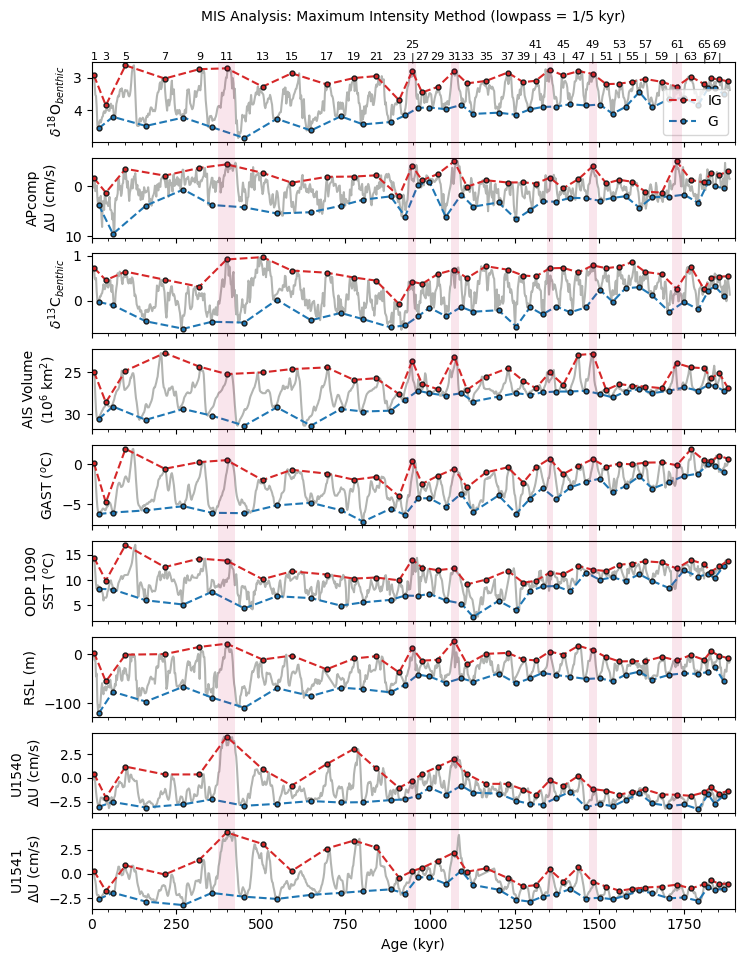

In [18]:
f,ax = plt.subplots(9,1,sharex=True,figsize=(11,14))
ms = 3.5
## d18o
ax[0].plot(lp['age'],lp['c18O_lpf'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='c18O',ax=ax[0],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red',label='IG')
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='c18O',ax=ax[0],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue',label='G')
ax[0].invert_yaxis()
ax[0].set_ylabel('$\\delta ^{18}$O$_{benthic}$')

## SS
ax[1].plot(lp['age'],lp['SS_lpf'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='SS',ax=ax[1],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='SS',ax=ax[1],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[1].invert_yaxis()
ax[1].set_ylabel('APcomp\n$\\Delta$U (cm/s)')

## d13Cbenthic
ax[2].plot(lp['age'],lp['c13C_lpf'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='c13C',ax=ax[2],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red',label='IG')
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='c13C',ax=ax[2],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue',label='G')
ax[2].set_ylabel('$\\delta ^{13}$C$_{benthic}$')


## AIS
ax[3].plot(lp['age'],lp['AIS_db'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='AIS_db',ax=ax[3],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='AIS_db',ax=ax[3],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[3].invert_yaxis()
ax[3].set_ylabel('AIS Volume\n($10^6$ km$^2$)')

## GAST
ax[4].plot(lp['age'],lp['gast'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='gast',ax=ax[4],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='gast',ax=ax[4],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[4].set_ylabel('GAST ($^o$C)')


## ODP 1090
ax[5].plot(lp['age'],lp['SST_1090'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='SST_1090',ax=ax[5],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='SST_1090',ax=ax[5],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[5].set_ylabel('ODP 1090\nSST ($^o$C)')

## RSL
ax[6].plot(lp['age'],lp['RSL'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='RSL',ax=ax[6],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='RSL',ax=ax[6],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[6].set_ylabel('RSL (m)')

## u1540
ax[7].plot(lp['age'],lp['u1540_SS'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='u1540',ax=ax[7],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='u1540',ax=ax[7],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[7].set_ylabel('U1540\n$\\Delta$U (cm/s)')

## u1541
ax[8].plot(lp['age'],lp['u1541_SS'],color='xkcd:grey',alpha=0.7)
mis_table[mis_table.index%2==0].plot(x='age_d18O',y='u1541',ax=ax[8],marker='o',linestyle='--',color='tab:blue',ms=ms,markeredgecolor='k',markerfacecolor='tab:blue')
mis_table[mis_table.index%2==1].plot(x='age_d18O',y='u1541',ax=ax[8],marker='o',linestyle='--',color='tab:red',ms=ms,markeredgecolor='k',markerfacecolor='tab:red')
ax[8].set_ylabel('U1541\n$\\Delta$U (cm/s)')

for a in ax[1:]:
    try:
        a.get_legend().remove()
    except:
        continue

    
    
ax[0].set_xlim(0,1900)
ax[-1].set_xlabel('Age (kyr)')


ymax = 10.6
# ax[-1].axvspan(12,19,clip_on=False,ymax=ymax,alpha=0.1)
for i in range(0,71):
    if i%2==1:
        ax[-1].axvspan(mis_bounds['Age(ka)'].loc[i],mis_bounds['Age(ka)'].loc[i+1],facecolor='k',alpha=0,ymax=ymax,clip_on=False,zorder=-1)
        if i in [25,41,45,49,53,57,61,65,69]:
            ax[0].text((mis_bounds['Age(ka)'].loc[i-1]+mis_bounds['Age(ka)'].loc[i])/2,2.45,str(i)+'\n|',ha='center',fontsize=8)
        else:
            ax[0].text((mis_bounds['Age(ka)'].loc[i-1]+mis_bounds['Age(ka)'].loc[i])/2,2.45,str(i),ha='center',fontsize=8)

        
cop = 'xkcd:ruby'
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[24],mis_bounds['Age(ka)'].loc[25],facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[30],mis_bounds['Age(ka)'].loc[31]+5,facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[10],mis_bounds['Age(ka)'].loc[11],facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[48],mis_bounds['Age(ka)'].loc[49],facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[42],mis_bounds['Age(ka)'].loc[43],facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)
ax[-1].axvspan(mis_bounds['Age(ka)'].loc[60],mis_bounds['Age(ka)'].loc[61],facecolor=cop,alpha=0.1,ymax=ymax,clip_on=False,zorder=-1)

ax[-1].xaxis.set_minor_locator(MultipleLocator(50))
ax[0].set_title('MIS Analysis: Maximum Intensity Method (lowpass = 1/5 kyr)\n\n',fontsize=10)


f.set_size_inches(8.3,11)
plt.tight_layout()
plt.savefig('figures/SF7_MIS_analysis.pdf',bbox_inches='tight')

## Additional MIS analysis figures


### Testing correlation between variables
- Not every variable in the MIS ensemble table is normally distirbuted (i.e. Sortable Silt fails a D’Agostino normality test)
- Therefore we should consider a Rank correlation instead of/as well as a standard Pearson correlation test


In [19]:
k2, p = stats.normaltest(mis_table['SS'])
alpha = 1e-3
print("p = {:g}".format(p))
p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 0.479375
The null hypothesis can be rejected


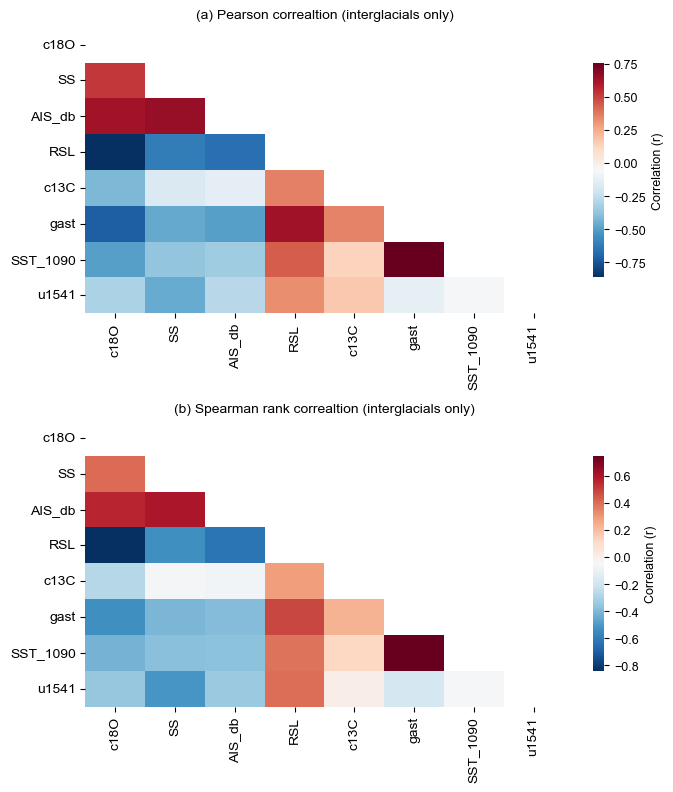

<Figure size 640x480 with 0 Axes>

In [20]:
f,ax = plt.subplots(2,1)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 9

mask = np.triu(np.ones_like(mis_table[mis_table['g_ig']=='IG'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr(), dtype=bool))

## Pearson
corr_matrix = mis_table[mis_table['g_ig']=='IG'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr()
cf = sns.heatmap(corr_matrix, annot=True,cmap='RdBu_r',cbar_kws={'label':'Correlation (r)','shrink':0.75},ax=ax[0],mask=mask)
ax[0].set_title('(a) Pearson correaltion (interglacials only)',fontsize=10)

## Spearman Rank
rank_matrix = mis_table[mis_table['g_ig']=='IG'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr(method='spearman')
sns.heatmap(rank_matrix, annot=True,cmap='RdBu_r',cbar_kws={'label':'Correlation (r)','shrink':0.75},ax=ax[1],mask=mask)
ax[1].set_title('(b) Spearman rank correaltion (interglacials only)',fontsize=10)

plt.gcf().set_size_inches(7,8)
plt.tight_layout()
plt.show()
plt.savefig('figures/SF8_MIS_comparison.pdf',bbox_inches='tight')

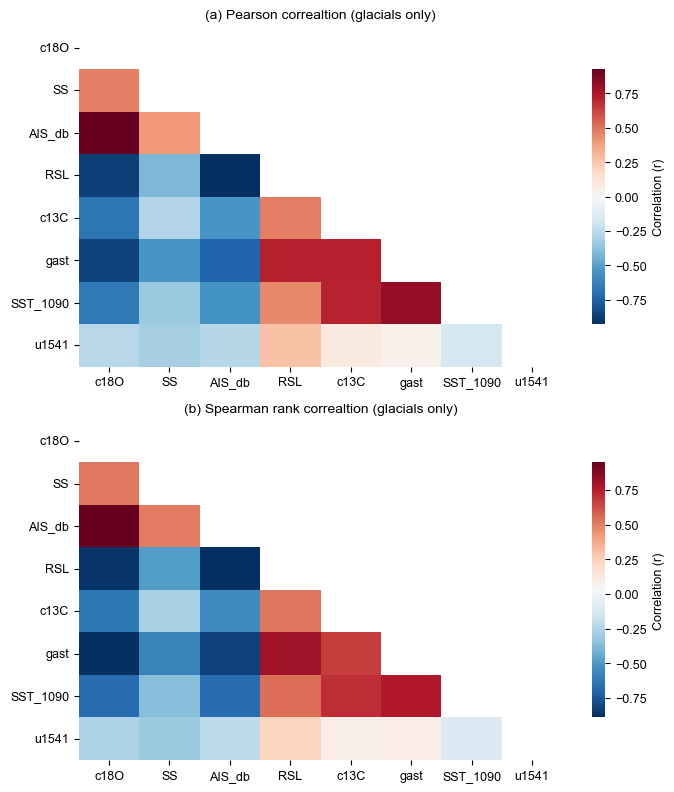

In [21]:
f,ax = plt.subplots(2,1)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 9

mask = np.triu(np.ones_like(mis_table[mis_table['g_ig']=='G'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr(), dtype=bool))

## Pearson
corr_matrix = mis_table[mis_table['g_ig']=='G'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr()
cf = sns.heatmap(corr_matrix, annot=True,cmap='RdBu_r',cbar_kws={'label':'Correlation (r)','shrink':0.75},ax=ax[0],mask=mask)
ax[0].set_title('(a) Pearson correaltion (glacials only)',fontsize=10)

## Spearman Rank
rank_matrix = mis_table[mis_table['g_ig']=='G'][['c18O','SS','AIS_db','RSL','c13C','gast','SST_1090','u1541']].corr(method='spearman')
sns.heatmap(rank_matrix, annot=True,cmap='RdBu_r',cbar_kws={'label':'Correlation (r)','shrink':0.75},ax=ax[1],mask=mask)
ax[1].set_title('(b) Spearman rank correaltion (glacials only)',fontsize=10)



plt.gcf().set_size_inches(7,8)
plt.tight_layout()
# plt.savefig('figures/SF8_MIS_glacial_comparison.pdf',bbox_inches='tight')

----
## AIS model comparison
- compa
re correlation between de Boer's AIS simulation and Sutter's simulation ensembles
- Ensemble simulations of AIS evolution across the MPT presented in [Sutter et al., 2019](https://doi.org/10.5194/tc-13-2023-2019). 


In [36]:

# # Sutter PISM
# B1 = EDC to LR04 climate index
b1 = pd.read_csv('data/Sutter/B1_ensemble.csv')
# B2 = Snyder global temperature
b2 = pd.read_csv('data/Sutter/B2_ensemble.csv')
b1['Age'] = round(b1['Time']*-1,5)/1000
b2['Age'] = round(b2['Time']*-1,5)/1000
b1 = b1.sort_values(by='Age').reset_index()
b2 = b2.sort_values(by='Age').reset_index()
b1.loc[0]['Age'] = 0
b2.loc[0]['Age'] = 0


b1

,index,Time,Median,90%,10%,95%,5%,max,min,Age
0,1979999,0.0,2.797641e+16,2.924956e+16,2.717839e+16,2.931599e+16,2.700147e+16,3.067579e+16,2.679528e+16,-0.000
1,1979998,-1.0,2.797653e+16,2.925019e+16,2.717857e+16,2.931671e+16,2.700191e+16,3.067671e+16,2.679481e+16,0.001
2,1979997,-2.0,2.797647e+16,2.925049e+16,2.717830e+16,2.931709e+16,2.700200e+16,3.067609e+16,2.679501e+16,0.002
3,1979996,-3.0,2.797666e+16,2.924991e+16,2.717800e+16,2.931664e+16,2.700124e+16,3.067614e+16,2.679538e+16,0.003
4,1979995,-4.0,2.797680e+16,2.924985e+16,2.717815e+16,2.931657e+16,2.700117e+16,3.067584e+16,2.679459e+16,0.004
...,...,...,...,...,...,...,...,...,...,...
1979995,4,-1979995.0,2.642276e+16,2.643174e+16,2.640419e+16,2.643204e+16,2.639873e+16,2.643300e+16,2.639252e+16,1979.995
1979996,3,-1979996.0,2.642413e+16,2.643320e+16,2.640665e+16,2.643342e+16,2.640111e+16,2.643426e+16,2.639426e+16,1979.996
1979997,2,-1979997.0,2.642603e+16,2.643574e+16,2.640860e+16,2.643641e+16,2.640383e+16,2.643745e+16,2.639664e+16,1979.997
1979998,1,-1979998.0,2.642886e+16,2.643954e+16,2.641239e+16,2.644064e+16,2.640777e+16,2.644132e+16,2.640058e+16,1979.998


In [54]:
######### RUN THIS CELL TO FIND MIS VALUES ###############
lp_sup = pd.DataFrame() # init supplemental dataframe
 
#### --- APcomp --- ####
apcomp['MIS'] = find_MIS_values(apcomp['LR04_age'],mis_bounds)

# benthic d18O
n = apcomp['Cwu d18O (VPDB)'].notnull() # find nans
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['Cwu d18O (VPDB)'][n],lpf,newdt=newdt) # low pass filter and return
lp_sup['age'] = t
lp_sup['c18O'] = pp
lp_sup['c18O_lpf'] = y

# Sortable Silt
n = apcomp['dU_dhol_mccave'].notnull()
t,y,pp = filtered(apcomp['LR04_age'][n],apcomp['dU_dhol_mccave'][n],lpf,tnew=t)
lp_sup['SS'] = pp
lp_sup['SS_lpf'] = y

#### --- AIS De Boer --- ####
deboer['MIS'] = find_MIS_values(deboer['Age'],mis_bounds)
n = deboer['AnIS-V'].notnull()
t_0,y,pp = filtered(deboer['Age'][n],deboer['AnIS-V'][n],lpf,tnew=lp_sup['age'])
lp_sup['AIS_db'] = pp
lp_sup['AIS_db_lpf'] = y

# De Boer sea level
# n = deboer['Sea level'].notnull()
# t_0,y,pp = filtered(deboer['Age'][n],deboer['Sea level'][n],lpf,tnew=lp_sup['age'])
# lp_sup['SL_db'] = pp
# lp_sup['SL_db_lpf'] = y

#### --- AIS Sutter B1 --- ####
## B1
b1['MIS'] = find_MIS_values(b1['Age'],mis_bounds)
n = b1['Median'].notnull()
t_0,y,pp = filtered(b1['Age'][n],b1['Median'][n],lpf,tnew=lp_sup['age'])
lp_sup['b1'] = pp/10**15
lp_sup['b1_lpf'] = y/10**15

## B2
b2['MIS'] = find_MIS_values(b2['Age'],mis_bounds)
n = b2['Median'].notnull()
t_0,y,pp = filtered(b2['Age'][n],b2['Median'][n],lpf,tnew=lp_sup['age'])
lp_sup['b2'] = pp/10**15
lp_sup['b2_lpf'] = y/10**15



####################### FIND MIS in lp ###################
### Find MIS 
lp_sup['MIS'] = find_MIS_values(lp_sup['age'],mis_bounds)




# ############ --------- calculate MIS values from lp ----------- #############
mis_values_max = lp_sup.groupby('MIS').max().copy(deep=True)
mis_values_min = lp_sup.groupby('MIS').min().copy(deep=True)
mis_values_mean = lp_sup.groupby('MIS').mean().copy(deep=True)
mis_values_max['Age_mid (kyr)'] = mis_values_mean['age']
mis_values_min['Age_mid (kyr)'] = mis_values_mean['age']

    
# ###### ------ APcomp ----- #######
# d18Obenthic
mis_table_sup = pd.DataFrame(index=mis_values_max.index)
mis_table_sup['c18O'] = mis_values_max[(mis_values_mean.index%2)==0]['c18O_lpf']
n = mis_table_sup['c18O'].notnull()
mis_table_sup['c18O'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['c18O_lpf'][~n]

# SS
mis_table_sup['SS'] = mis_values_max[(mis_values_mean.index%2)==0]['SS_lpf']
n = mis_table_sup['SS'].notnull()
mis_table_sup['SS'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['SS_lpf'][~n]

# AIS_db
mis_table_sup['AIS_db'] = mis_values_max[(mis_values_mean.index%2)==0]['AIS_db_lpf']
n = mis_table_sup['AIS_db'].notnull()
mis_table_sup['AIS_db'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['AIS_db_lpf'][~n]

# B2
mis_table_sup['b2'] = mis_values_max[(mis_values_mean.index%2)==0]['b2_lpf']
n = mis_table_sup['b2'].notnull()
mis_table_sup['b2'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['b2_lpf'][~n]

# B1
mis_table_sup['b1'] = mis_values_max[(mis_values_mean.index%2)==0]['b1_lpf']
n = mis_table_sup['b1'].notnull()
mis_table_sup['b1'][~n] = mis_values_min[(mis_values_mean.index%2)==1]['b1_lpf'][~n]




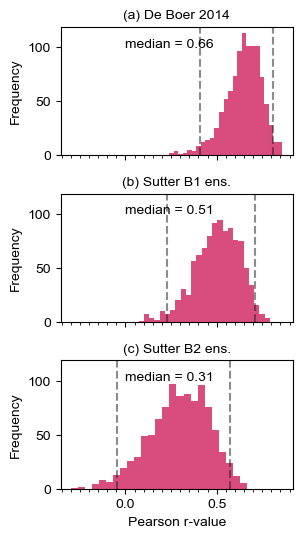

In [55]:
from scipy.stats import bootstrap
from scipy.stats import pearsonr

#### INTERGLACIAL PEARSON R
rng = np.random.default_rng()

def replicate(data1,data2,sims=10000,stat=np.corrcoef):
    rep=np.empty(sims)
    for i in range(sims):
        inds=np.random.choice(a=data1.index,size=len(data1),
                          replace=True)
        rep[i]=stat(data1.loc[inds],data2.loc[inds])[0,1]
    return(rep)

corr = {}
for y in ['AIS_db','b1','b2']:
    corr[y] =replicate(mis_table_sup[mis_table.index%2==1]['SS'],mis_table_sup[mis_table.index%2==1][y],sims=1000,stat=np.corrcoef)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 10

fig, ax = plt.subplots(3,1,figsize=(3,6),sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.3)
for i,y in enumerate(['AIS_db','b1','b2']):
    ax[i].hist(corr[y], bins=25,alpha=0.7,fc='xkcd:ruby')
    ax[i].axvline(np.percentile(corr[y],[2.5]).round(3),c='k',linestyle='--',alpha=0.5)
    ax[i].axvline(np.percentile(corr[y],[97.5]).round(3),c='k',linestyle='--',alpha=0.5)
    #ax[i].set_title(y)
    ax[i].set_ylabel('Frequency')
ax[2].set_xlabel('Pearson r-value')

ax[0].set_title('(a) De Boer 2014',fontsize=10)
ax[1].set_title('(b) Sutter B1 ens.',fontsize=10)
ax[2].set_title('(c) Sutter B2 ens.',fontsize=10)


ax[0].text(0,100,'median = '+str(np.round(np.median(corr['AIS_db']),2)))
ax[1].text(0,100,'median = '+str(np.round(np.median(corr['b1']),2)))
ax[2].text(0,100,'median = '+str(np.round(np.median(corr['b2']),2)))
ax[-1].xaxis.set_minor_locator(MultipleLocator(0.05))

plt.savefig('figures/SF9a_IG_pearson.pdf')

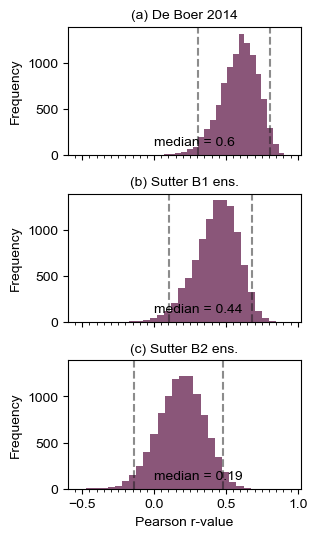

In [56]:
from scipy.stats import spearmanr

#### SPEARMAN RANK
rng = np.random.default_rng()

def replicate(data1,data2,sims=10000):
    rep=np.empty(sims)
    for i in range(sims):
        inds=np.random.choice(data1.index,size=len(data1),
                          replace=True)
        rep[i],_=spearmanr(data1.loc[inds].values,data2.loc[inds].values)
    return(rep)

corr = {}
for y in ['AIS_db','b1','b2']:
    corr[y] = replicate(mis_table_sup[mis_table.index%2==1]['SS'],mis_table_sup[mis_table.index%2==1][y])

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 10

fig, ax = plt.subplots(3,1,figsize=(3,6),sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.3)
for i,y in enumerate(['AIS_db','b1','b2']):
    ax[i].hist(corr[y], bins=25,alpha=0.7,fc='xkcd:plum')
    ax[i].axvline(np.percentile(corr[y],[2.5]).round(3),c='k',linestyle='--',alpha=0.5)
    ax[i].axvline(np.percentile(corr[y],[97.5]).round(3),c='k',linestyle='--',alpha=0.5)
    #ax[i].set_title(y)
    ax[i].set_ylabel('Frequency')
ax[2].set_xlabel('Pearson r-value')

ax[0].set_title('(a) De Boer 2014',fontsize=10)
ax[1].set_title('(b) Sutter B1 ens.',fontsize=10)
ax[2].set_title('(c) Sutter B2 ens.',fontsize=10)


ax[0].text(0,100,'median = '+str(np.round(np.median(corr['AIS_db']),2)))
ax[1].text(0,100,'median = '+str(np.round(np.median(corr['b1']),2)))
ax[2].text(0,100,'median = '+str(np.round(np.median(corr['b2']),2)))
ax[-1].xaxis.set_minor_locator(MultipleLocator(0.05))

plt.savefig('figures/SF9b_IG_spearman.pdf')

In [57]:
np.percentile(corr['AIS_db'],[97.5]).round(3)[0]

0.808

In [58]:
np.percentile(corr['AIS_db'],[2.5]).round(3)[0]

0.309